In [158]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from google.cloud.storage.blob import Blob
from google.cloud import storage

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [74]:
# Method to write dataframe to the GCP bucket
'''
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'mlb-mvp-predictions-571fb58bbad3.json'

client = storage.Client()
bucket = client.get_bucket('football-hackathan')
bucket.blob('corr_matrix.csv').upload_from_string(corr_matrix.to_csv(), 'text/csv')
'''

"\nos.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'mlb-mvp-predictions-571fb58bbad3.json'\n\nclient = storage.Client()\nbucket = client.get_bucket('football-hackathan')\nbucket.blob('corr_matrix.csv').upload_from_string(corr_matrix.to_csv(), 'text/csv')\n"

In [75]:
soccer_file = pd.read_csv('gs://football-hackathan/train.csv')
soccer_test = pd.read_csv('gs://football-hackathan/test.csv')

# EDA and Data Processing

In [76]:
# summary statistics
soccer_file.describe()

,row_id,scout_id,rating_num,competitionId,player_position_1,player_position_2,player_height,player_weight,player_general_var_0,player_general_var_1,...,team2_defensive_derived_var_10,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19
count,20453.000000,20453.000000,20453.000000,20453.000000,20378.000000,20378.000000,20451.000000,20451.000000,20453.000000,20453.000000,...,19026.000000,20332.000000,19019.000000,19021.000000,19026.000000,19026.000000,19026.000000,19026.000000,19026.000000,19026.000000
mean,14257.557033,10.023566,6.887303,7.311837,7.609481,8.012612,0.496925,0.455471,0.029717,0.003276,...,0.350022,0.179766,0.253738,0.582760,0.480930,0.497442,0.113251,0.424523,0.420103,0.333038
std,8353.543104,5.712044,1.852367,2.345699,5.059591,4.913142,0.160769,0.140848,0.082089,0.057142,...,0.140589,0.059541,0.138928,0.150763,0.163294,0.135420,0.061303,0.098739,0.121958,0.143902
min,1.000000,1.000000,0.000000,4.000000,1.000000,1.000000,0.024390,0.040000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.046945,0.000000,0.044144,0.000000,0.000000
25%,7048.000000,3.000000,6.000000,5.000000,3.000000,3.000000,0.390244,0.340000,0.000000,0.000000,...,0.246247,0.158557,0.153925,0.485600,0.365868,0.410089,0.068929,0.357223,0.333557,0.235558
50%,14093.000000,12.000000,6.500000,7.000000,7.000000,8.000000,0.512195,0.440000,0.000000,0.000000,...,0.339490,0.184254,0.239381,0.592093,0.479270,0.499538,0.102904,0.421710,0.420148,0.320256
75%,21381.000000,15.000000,8.000000,9.000000,11.000000,11.000000,0.609756,0.540000,0.000000,0.000000,...,0.431876,0.215570,0.338749,0.691803,0.596090,0.594952,0.149055,0.489914,0.507056,0.425171
max,29227.000000,26.000000,10.000000,15.000000,23.000000,23.000000,0.975610,1.000000,1.000000,1.000000,...,0.962835,1.000000,1.000000,1.000000,0.989602,0.977524,1.000000,1.000000,1.000000,1.000000


In [77]:
# How many scouts are there?
num_scouts = len(pd.unique(soccer_file['scout_id']))
print('Number of scouts: ', num_scouts)

# How many player positions are there
num_position1 = len(pd.unique(soccer_file['player_position_1']))
num_position2 = len(pd.unique(soccer_file['player_position_2']))
print('Number of position1: ', num_position1)
print('Number of position2: ', num_position2)

# How many competitions are there
num_competition = len(pd.unique(soccer_file['competitionId']))
print('Number of competition IDs: ', num_competition)

Number of scouts:  21
Number of position1:  23
Number of position2:  23
Number of competition IDs:  10


### Average rating by variable

In [78]:
# Number of players with the given ratings
cols = {'rating_num': 'num_of_players'}
num_ratings = soccer_file.groupby('rating_num').agg({'rating_num':'count'}).rename(columns = cols)
num_ratings

,num_of_players
rating_num,
0.0,218
2.0,49
3.0,110
3.5,1077
5.0,2244
6.0,3654
6.5,3247
7.0,1248
7.5,3206


In [79]:
# Average ratings by variable

# Average rating by scout
cols = {'rating_num': 'rating_avg', 'scout_id': 'players_scouted'}
avg_scout = soccer_file.groupby('scout_id').agg({'rating_num':'mean', 'scout_id':'count'}).rename(columns = cols)
avg_scout

,rating_avg,players_scouted
scout_id,,
1,6.619615,1973
2,6.687905,926
3,7.100000,2740
4,6.473607,1023
5,6.857914,278
8,7.500000,1
10,7.919530,553
11,6.634231,2302
12,7.254073,982


In [80]:
# Average rating and number of players by position1
cols = {'rating_num':'avg_rating', 'player_position_1': 'number_of_players'}
avg_position1 = soccer_file.groupby('player_position_1').agg({'rating_num':'mean', 'player_position_1':'count'}).rename(columns = cols)
avg_position1

,avg_rating,number_of_players
player_position_1,,
1.0,6.758749,1743
2.0,6.724986,1789
3.0,6.938181,3211
4.0,7.083531,1263
5.0,6.819714,979
6.0,7.304856,556
7.0,6.631092,1190
8.0,6.619965,1142
9.0,7.144699,698


In [81]:
soccer_file.iloc[:,0:15]

,row_id,scout_id,rating_num,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,player_general_var_0,player_general_var_1,player_general_var_2,player_general_var_3,player_general_var_4
0,1,13,7.0,winner,team1,8,7.0,7.0,0.317073,0.48,0.0,0,0.0,0.0,0.114754
1,3,16,6.5,loser,team2,8,3.0,9.0,0.463415,0.42,0.0,0,0.0,0.0,0.081967
2,4,4,8.5,loser,team1,5,11.0,11.0,0.682927,0.44,0.0,0,0.0,0.0,0.065574
3,5,13,8.0,loser,team2,4,17.0,17.0,0.682927,0.58,0.0,0,0.0,0.0,0.000000
4,7,11,3.5,draw,team1,5,10.0,10.0,0.731707,0.70,0.0,0,0.0,0.0,0.262295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20448,29221,14,5.0,draw,team2,14,NaN,NaN,0.439024,0.26,0.0,0,0.0,0.0,0.049180
20449,29223,3,6.0,winner,team2,11,4.0,4.0,0.390244,0.32,0.0,0,0.0,0.0,0.122951
20450,29224,4,5.0,loser,team1,7,5.0,5.0,0.268293,0.30,0.0,0,0.0,0.0,0.155738
20451,29226,13,6.0,loser,team1,8,5.0,5.0,0.463415,0.46,0.0,0,0.0,0.0,0.229508


In [82]:
# Categorical variables
categorical_cols = soccer_file.select_dtypes(include=['object']).copy()
categorical_cols

,winner,team
0,winner,team1
1,loser,team2
2,loser,team1
3,loser,team2
4,draw,team1
...,...,...
20448,draw,team2
20449,winner,team2
20450,loser,team1
20451,loser,team1


### Handling the missing data

In [83]:
# number of rows with missing entries
soccer_file.isnull().any(axis = 1).sum()

20453

In [84]:
# number of null values by column
missing_list = list(soccer_file.isnull().sum())
col_list = list(soccer_file.columns)
missing_percent = []
for val in missing_list:
    percentage = val/len(soccer_file)
    missing_percent.append(percentage)


missing_dict = tuple(zip(col_list, missing_list, missing_percent))
missing_df = pd.DataFrame(missing_dict, columns = ['column_title', 'abs_missing', 'pct_missing'])
    


In [85]:
large_missing = missing_df.sort_values(by = ['abs_missing'], ascending = False)
large_missing

,column_title,abs_missing,pct_missing
652,team2_other_raw_var_19,20453,1.0
515,team1_other_raw_var_50,20453,1.0
537,team1_other_raw_var_72,20453,1.0
484,team1_other_raw_var_19,20453,1.0
496,team1_other_raw_var_31,20453,1.0
...,...,...,...
12,player_general_var_2,0,0.0
13,player_general_var_3,0,0.0
15,player_general_var_5,0,0.0
1,scout_id,0,0.0


In [86]:
# columns with more than 40% missing values
df_missing = missing_df[missing_df['pct_missing'] >= 0.4]
missing_cols = list(df_missing['column_title'])

In [87]:
soccer_file = soccer_file.drop(columns = missing_cols)
soccer_test = soccer_test.drop(columns = missing_cols)

In [88]:
# One-hot encode the categorical variables in the dataset
soccer_file = pd.get_dummies(soccer_file, columns = ['winner', 'team', 'player_position_1', 'player_position_2'])
soccer_test = pd.get_dummies(soccer_test, columns = ['winner', 'team', 'player_position_1', 'player_position_2'])

In [89]:
# fill the missing values of the dataframe with the mean values
soccer_file = soccer_file.apply(lambda x: x.fillna(x.mean()), axis = 0)

In [90]:
soccer_test = soccer_test.apply(lambda x: x.fillna(x.mean()), axis = 0)
soccer_test = soccer_test.drop(columns = 'row_id')

In [91]:
# number of rows with missing entries
soccer_test.isnull().any(axis = 1).sum()

0

In [24]:
# Put together a correlation matrix
# Drop the unwanted data fields
corr_df = soccer_file.drop(columns = ['row_id', 'scout_id'])

In [48]:
corr_matrix = soccer_file.corr()

In [49]:
corr_matrix

,row_id,scout_id,rating_num,competitionId,player_position_1,player_position_2,player_height,player_weight,player_general_var_0,player_general_var_1,...,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19,winner_draw,winner_loser,winner_winner,team_team1,team_team2
row_id,1.000000,0.017885,-0.167852,0.032443,0.003965,0.005554,-0.012078,-0.010551,-0.037521,0.001232,...,-0.002126,-0.009874,-0.005428,-0.008082,0.026936,-0.000790,0.054481,-0.050462,-0.010651,0.010651
scout_id,0.017885,1.000000,0.013590,0.041903,-0.010558,-0.007104,-0.021856,-0.038816,0.003574,-0.003382,...,0.013332,-0.003362,0.027326,0.033307,0.020558,-0.008517,-0.003350,0.010679,-0.004946,0.004946
rating_num,-0.167852,0.013590,1.000000,-0.068516,0.019457,0.022495,-0.014785,-0.053880,0.117848,-0.020071,...,0.010867,0.025713,0.016586,0.033952,-0.011991,0.005345,-0.166952,0.152048,-0.000583,0.000583
competitionId,0.032443,0.041903,-0.068516,1.000000,-0.002132,-0.007870,0.010574,-0.011889,0.027847,0.000404,...,0.014912,0.000775,-0.019079,0.196055,-0.018709,-0.019688,-0.025841,0.041679,-0.020252,0.020252
player_position_1,0.003965,-0.010558,0.019457,-0.002132,1.000000,0.954262,-0.080985,-0.040299,0.130674,-0.030808,...,0.001327,0.005485,0.014589,-0.011718,0.007915,0.005663,-0.007477,0.002012,-0.005659,0.005659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
winner_draw,-0.000790,-0.008517,0.005345,-0.019688,0.005663,0.002894,-0.013064,-0.012070,-0.051714,-0.004465,...,-0.043783,-0.033381,-0.002346,-0.084574,0.059529,1.000000,-0.399793,-0.509054,-0.013524,0.013524
winner_loser,0.054481,-0.003350,-0.166952,-0.025841,-0.007477,-0.003052,0.023966,0.020965,-0.150585,0.027442,...,0.012228,0.020859,0.004190,0.000973,-0.021394,-0.399793,1.000000,-0.585437,-0.084428,0.084428
winner_winner,-0.050462,0.010679,0.152048,0.041679,0.002012,0.000306,-0.010950,-0.009012,0.187147,-0.021820,...,0.027407,0.010078,-0.001846,0.074180,-0.032792,-0.509054,-0.585437,1.000000,0.091243,-0.091243
team_team1,-0.010651,-0.004946,-0.000583,-0.020252,-0.005659,-0.006422,-0.000641,0.007603,0.025181,-0.003013,...,-0.079267,-0.087313,-0.043039,-0.063959,-0.009904,-0.013524,-0.084428,0.091243,1.000000,-1.000000


# Feature Reduction

In [92]:
# Isolate the rating_num dependent variable from the rest of the features
rating_dep = soccer_file['rating_num']
ind_vars = soccer_file.drop(columns = ['rating_num', 'row_id'])

In [93]:
ind_vars.shape

(20453, 774)

In [94]:
# Normalize the independent variables on a scale of 0 to 1
scaler = MinMaxScaler()

scale = MinMaxScaler().fit(ind_vars)
soccer_train = scale.transform(ind_vars)

# apply the same normalization to the testing dataset
soccer_test_norm = scale.transform(soccer_test)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- player_position_1_21.0
- player_position_2_21.0
Feature names seen at fit time, yet now missing:
- player_position_1_22.0
- player_position_2_22.0

  warnings.warn(message, FutureWarning)


In [95]:
soccer_train = pd.DataFrame(soccer_train, columns = ind_vars.columns)
# soccer_train['rating_num'] = rating_dep

soccer_test_norm = pd.DataFrame(soccer_test_norm, columns = soccer_test.columns)

In [96]:
components = None
pca = PCA(n_components = components)

pca.fit(soccer_train)

PCA()

Text(0, 0.5, 'Explained variance %')

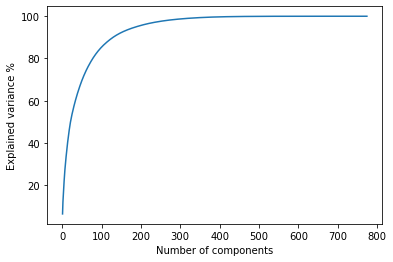

In [97]:
# Scree plot of the principal components
components = len(pca.explained_variance_ratio_) \
    if components is None else components

plt.plot(range(1, components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance %')

## PCA accounting for 85% of the variance

Cumulative Variances (Percentage):
[ 6.35344733 12.02883852 15.66851704 18.95442302 21.92832096 24.75417194
 27.25644477 29.51729843 31.49188272 33.41532591 35.25877803 37.04578584
 38.78262002 40.37835145 41.87746796 43.32448241 44.75307902 46.12854242
 47.42841655 48.61292833 49.75369466 50.74347511 51.70093138 52.62974917
 53.52005132 54.35265635 55.15934609 55.94441179 56.71159988 57.46969763
 58.22152742 58.92053217 59.6085089  60.2887495  60.9638884  61.62676348
 62.27481352 62.8937417  63.49353132 64.09061432 64.66501853 65.23636875
 65.8061969  66.36713202 66.92305813 67.46056079 67.98765156 68.50430006
 68.99990289 69.49411447 69.98209134 70.46070455 70.92010589 71.37534315
 71.81190526 72.24727993 72.67369167 73.08777355 73.49921014 73.90642401
 74.30840744 74.7056959  75.0882779  75.45550831 75.81895727 76.17532005
 76.52748133 76.87433544 77.2159589  77.5543217  77.88417933 78.21182237
 78.53111609 78.84876558 79.16312777 79.46831027 79.76550234 80.06166241
 80.35079516 80.

Text(0, 0.5, 'Explained variance (%)')

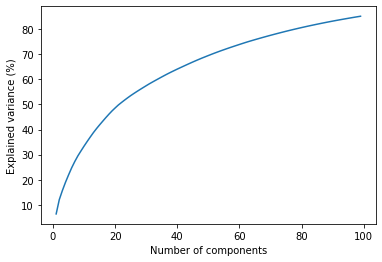

In [98]:
pca = PCA(n_components = 0.85)
pca.fit(soccer_train)

print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')


plt.plot(range(1, components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

### Transform the independent variables to the 94 principal components

In [99]:
x_pca = pca.transform(soccer_train)

In [100]:
x_pca.shape

(20453, 99)

In [101]:
x_pca = pd.DataFrame(x_pca)

In [102]:
x_pca['rating_num'] = rating_dep

In [31]:
x_pca

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,rating_num
0,-0.647216,1.318906,-0.892417,-0.455649,0.411742,0.181474,-0.502134,0.548443,-0.083125,0.195436,...,-0.143577,0.038107,-0.097028,0.080858,0.075371,0.106086,-0.108529,-0.088648,-0.303706,7.0
1,2.361603,0.631024,0.330726,-0.382105,-0.611905,-0.651974,0.417485,-0.791841,-1.057442,0.219323,...,-0.267848,0.025736,-0.034409,0.016696,0.089431,-0.199130,0.171138,-0.094553,-0.173094,6.5
2,0.085779,-0.877735,-0.260446,0.451692,-1.037877,0.340986,0.074575,-0.251533,0.751789,0.533529,...,-0.212561,0.059643,0.356824,0.040200,-0.131884,-0.294562,-0.175926,-0.020444,0.002438,8.5
3,0.282274,0.424787,1.202795,0.328410,-0.140340,-0.278052,1.612118,1.300970,-0.580653,0.002107,...,-0.089635,-0.034306,-0.147899,-0.036836,0.089226,0.135129,0.159408,-0.173048,-0.108412,8.0
4,-0.262425,-1.144025,-0.784889,0.232681,-0.749756,0.156981,-0.295839,0.516396,-0.340433,-0.653335,...,-0.375330,0.218874,-0.088569,0.260140,-0.394890,-0.055578,0.167298,0.043855,0.060326,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20448,0.116784,-0.181548,0.652478,-0.153504,0.192087,0.004882,-0.534824,0.167872,-0.398166,-0.097987,...,-0.029807,0.121506,-0.047939,-0.006410,0.063671,-0.008088,0.012599,-0.020653,-0.095554,5.0
20449,-0.340687,0.703606,0.535768,-1.055274,0.466853,0.117993,-0.039721,0.437509,0.323641,1.366136,...,-0.197085,0.010098,-0.022531,0.031618,-0.041284,0.354377,0.129166,0.080832,0.012957,6.0
20450,1.959777,-0.948128,-0.651235,0.646628,-0.879539,-0.138110,0.512408,-0.617815,1.085211,-0.352635,...,-0.111140,0.127424,0.138977,-0.157132,-0.005588,-0.182568,0.021733,-0.229540,0.030229,5.0
20451,0.235793,1.143373,0.301462,0.760742,-0.543285,-0.283618,0.107563,-0.364992,0.557668,-0.071270,...,-0.153988,-0.203606,0.191428,0.089222,-0.047368,0.067747,-0.190948,0.054986,0.160419,6.0


## Feature reduction -

In [55]:
soccer_train

,scout_id,competitionId,player_position_1,player_position_2,player_height,player_weight,player_general_var_0,player_general_var_1,player_general_var_2,player_general_var_3,...,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19,winner_draw,winner_loser,winner_winner,team_team1,team_team2
0,0.48,0.363636,0.272727,0.272727,0.307692,0.458333,0.0,0.0,0.0,0.0,...,0.323493,0.034157,0.256124,0.310727,0.204925,0.0,0.0,1.0,1.0,0.0
1,0.60,0.363636,0.090909,0.363636,0.461538,0.395833,0.0,0.0,0.0,0.0,...,0.453515,0.054034,0.304248,0.380073,0.295392,0.0,1.0,0.0,0.0,1.0
2,0.12,0.090909,0.454545,0.454545,0.692308,0.416667,0.0,0.0,0.0,0.0,...,0.424256,0.219441,0.387238,0.570757,0.437500,0.0,1.0,0.0,1.0,0.0
3,0.48,0.000000,0.727273,0.727273,0.692308,0.562500,0.0,0.0,0.0,0.0,...,0.516655,0.095201,0.396394,0.330754,0.235558,0.0,1.0,0.0,0.0,1.0
4,0.40,0.090909,0.409091,0.409091,0.743590,0.687500,0.0,0.0,0.0,0.0,...,0.737905,0.128719,0.422883,0.444946,0.312500,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20448,0.52,0.909091,0.300431,0.318755,0.435897,0.229167,0.0,0.0,0.0,0.0,...,0.484104,0.113251,0.397946,0.420103,0.333038,1.0,0.0,0.0,0.0,1.0
20449,0.08,0.636364,0.136364,0.136364,0.384615,0.291667,0.0,0.0,0.0,0.0,...,0.233327,0.171927,0.396326,0.588501,0.534694,0.0,0.0,1.0,0.0,1.0
20450,0.12,0.272727,0.181818,0.181818,0.256410,0.270833,0.0,0.0,0.0,0.0,...,0.883379,0.296820,0.488992,0.548315,0.385927,0.0,1.0,0.0,1.0,0.0
20451,0.48,0.363636,0.181818,0.181818,0.461538,0.437500,0.0,0.0,0.0,0.0,...,0.295744,0.108018,0.302436,0.349177,0.458685,0.0,1.0,0.0,1.0,0.0


## Linear Regression Testing

In [103]:
regression_data = x_pca.copy()

In [104]:
x = regression_data.iloc[:,:-1]
y = regression_data.iloc[:, -1]

In [105]:
# split the training dataset into a further training/testing split
# allows for evaluation of the model performance
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.33, shuffle = True, random_state = 1337)

In [106]:
linear_regression = LinearRegression()

In [107]:
# train the linear regression model
linear_regression.fit(x_train, y_train)

LinearRegression()

In [108]:
rating_pred = linear_regression.predict(x_test)

In [109]:
# mean squared error
print('mean squared error: %.2f' % mean_squared_error(y_test, rating_pred))
# r2 value
print('r2 of the linear regression: %.2f' % r2_score(y_test, rating_pred))

mean squared error: 3.01
r2 of the linear regression: 0.13


In [110]:
rating_pred

array([7.02966618, 6.83885771, 6.86084227, ..., 6.39725135, 7.42394345,
       7.21776215])

In [111]:
compare_df = pd.DataFrame(list(zip(y_test, rating_pred)), columns = ['actual', 'predicted'])

In [53]:
compare_df

,actual,predicted
0,0.0,6.968594
1,3.5,6.893652
2,6.5,6.887049
3,7.5,6.753580
4,8.0,6.620413
...,...,...
5109,5.0,6.857478
5110,6.0,6.509585
5111,7.5,6.598357
5112,5.0,7.365178


In [214]:
y_train

2933      8.0
11709     6.5
6320      7.5
11086     5.0
2857     10.0
         ... 
19111     5.0
19623    10.0
9448      3.5
860      10.0
3223      6.0
Name: rating_num, Length: 13703, dtype: float64

# Random Forest Implementation

## Feature Selection

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel

In [113]:
x = soccer_train
y = rating_dep

In [114]:
# split the training dataset into a further training/testing split
# allows for evaluation of the model performance
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, shuffle = True, random_state = 1337)

In [115]:
random_forest = RandomForestRegressor(n_estimators = 150)
random_forest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=150)

In [116]:
# create a feature importance plot
importance = random_forest.feature_importances_.argsort()

Text(0.5, 0, 'feature importance')

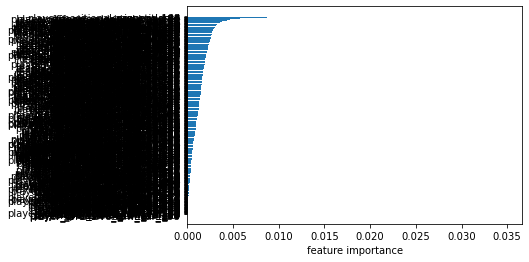

In [233]:
# plt.barh(soccer_train.columns[importance], random_forest.feature_importances_[importance])
# plt.xlabel('feature importance')

In [117]:
cols = soccer_train.columns[importance]
importances = random_forest.feature_importances_[importance]

In [118]:
importance_df = pd.DataFrame(list(zip(cols, importances)), columns = ['feature', 'importance'])

In [119]:
order_importance = importance_df.sort_values(by = ['importance'], ascending = False)
order_importance

,feature,importance
773,player_positional_raw_var_185,0.034337
772,winner_loser,0.022786
771,scout_id,0.014747
770,competitionId,0.010190
769,player_offensive_derived_var_55,0.008212
...,...,...
2,player_offensive_raw_var_156,0.000000
1,player_position_2_20.0,0.000000
4,player_position_2_22.0,0.000000
5,player_position_1_20.0,0.000000


In [123]:
# order_importance.to_csv('random_forest_importance.csv', index = False)

# Linear Regression - Random Forest selected variables

In [128]:
# select the variables with the x highest rated importance
order_importance = pd.read_csv('program_output/random_forest_importance.csv')
order_importance = order_importance.drop(columns = ['Unnamed: 0'])

In [130]:
order_importance

,feature,importance
0,player_positional_raw_var_185,0.034337
1,winner_loser,0.022786
2,scout_id,0.014747
3,competitionId,0.010190
4,player_offensive_derived_var_55,0.008212
...,...,...
769,player_offensive_raw_var_156,0.000000
770,player_position_2_20.0,0.000000
771,player_position_2_22.0,0.000000
772,player_position_1_20.0,0.000000


In [133]:
features = list(order_importance['feature'])[0:50]

In [ ]:
features

In [140]:
forest_frame = soccer_train[features]

In [144]:
forest_frame = forest_frame.drop(columns = ['scout_id'])

In [146]:
forest_frame['rating_num'] = rating_dep

In [147]:
forest_frame

,player_positional_raw_var_185,winner_loser,competitionId,player_offensive_derived_var_55,player_offensive_derived_var_127,player_offensive_derived_var_89,player_other_raw_var_38,player_other_derived_var_42,player_weight,player_other_raw_var_197,...,player_defensive_derived_var_109,player_other_ratio_var_41,player_positional_derived_var_130,team1_defensive_derived_var_17,team1_offensive_derived_var_0,team1_other_ratio_var_16,player_offensive_derived_var_17,player_other_ratio_var_9,team1_other_ratio_var_0,rating_num
0,0.281046,0.0,0.363636,0.263357,0.363880,0.351036,0.333333,0.268455,0.458333,0.789062,...,0.000000,0.681000,0.116477,0.463964,0.292824,0.250000,0.003983,0.375000,0.100000,7.0
1,0.076253,1.0,0.363636,0.046080,0.070982,0.059495,0.000000,0.077303,0.395833,0.304687,...,0.000000,0.588000,0.026901,0.527373,0.578956,0.355769,0.000609,0.500000,0.278000,6.5
2,0.058824,1.0,0.090909,0.228785,0.190847,0.183198,0.133333,0.250717,0.416667,0.515625,...,0.000000,0.714000,0.025403,0.398448,0.160841,0.301282,0.015572,0.500000,0.304000,8.5
3,0.004357,1.0,0.000000,0.248850,0.286793,0.276612,0.000000,0.270919,0.562500,0.549852,...,0.127292,0.143000,0.024101,0.604513,0.464588,0.250000,0.000000,0.517187,0.263000,8.0
4,0.102397,0.0,0.090909,0.233296,0.501211,0.523193,0.000000,0.271136,0.687500,0.585938,...,0.130109,0.609000,0.046619,0.343097,0.173852,0.291667,0.152078,0.400000,0.429000,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20448,0.150990,0.0,0.909091,0.234349,0.294352,0.287854,0.120437,0.273462,0.229167,0.549852,...,0.104130,0.569327,0.072637,0.515419,0.256878,0.372965,0.012474,0.517187,0.344758,5.0
20449,0.176471,0.0,0.636364,0.203672,0.404338,0.422112,0.000000,0.227776,0.291667,0.549852,...,0.232973,0.617000,0.072412,0.478794,0.351910,0.500000,0.008244,0.455000,0.250000,6.0
20450,0.026144,1.0,0.272727,0.092677,0.061061,0.059060,0.066667,0.113522,0.270833,0.414062,...,0.000000,0.500000,0.010461,0.410811,0.177651,0.275641,0.000000,0.750000,0.188000,5.0
20451,0.095861,1.0,0.363636,0.096719,0.107860,0.098498,0.200000,0.136147,0.437500,0.656250,...,0.047111,0.684000,0.041768,0.382713,0.152425,0.285256,0.001230,0.500000,0.375000,6.0


In [148]:
forest_data = forest_frame.copy()

In [149]:
x = forest_data.iloc[:,:-1]
y = forest_data.iloc[:, -1]

In [150]:
# split the training dataset into a further training/testing split
# allows for evaluation of the model performance
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, shuffle = True, random_state = 1337)

In [151]:
linear_regression = LinearRegression()

In [152]:
# train the linear regression model
linear_regression.fit(x_train, y_train)

LinearRegression()

In [153]:
rating_pred = linear_regression.predict(x_test)

In [154]:
# mean squared error
print('mean squared error: %.2f' % mean_squared_error(y_test, rating_pred))
# r2 value
print('r2 of the linear regression: %.2f' % r2_score(y_test, rating_pred))

mean squared error: 2.91
r2 of the linear regression: 0.14


In [157]:
forest_eval = pd.DataFrame(list(zip(y_test, rating_pred)), columns = ['actual','predict'])
forest_eval

,actual,predict
0,0.0,7.326479
1,3.5,6.944619
2,6.5,6.452716
3,7.5,6.942842
4,8.0,6.768663
...,...,...
5109,5.0,7.484972
5110,6.0,6.040504
5111,7.5,7.153547
5112,5.0,7.152994


# Random Forest Regression - 50 important variables

In [159]:
# select the variables with the x highest rated importance
order_importance = pd.read_csv('program_output/random_forest_importance.csv')
order_importance = order_importance.drop(columns = ['Unnamed: 0'])

In [160]:
order_importance

,feature,importance
0,player_positional_raw_var_185,0.034337
1,winner_loser,0.022786
2,scout_id,0.014747
3,competitionId,0.010190
4,player_offensive_derived_var_55,0.008212
...,...,...
769,player_offensive_raw_var_156,0.000000
770,player_position_2_20.0,0.000000
771,player_position_2_22.0,0.000000
772,player_position_1_20.0,0.000000


In [161]:
features = list(order_importance['feature'])[0:50]

In [162]:
features

['player_positional_raw_var_185',
 'winner_loser',
 'scout_id',
 'competitionId',
 'player_offensive_derived_var_55',
 'player_offensive_derived_var_127',
 'player_offensive_derived_var_89',
 'player_other_raw_var_38',
 'player_other_derived_var_42',
 'player_weight',
 'player_other_raw_var_197',
 'player_general_var_4',
 'team2_other_ratio_var_15',
 'player_height',
 'player_positional_derived_var_85',
 'player_positional_ratio_var_46',
 'team1_other_raw_var_36',
 'player_other_derived_var_76',
 'team2_other_ratio_var_16',
 'team2_other_raw_var_49',
 'player_other_ratio_var_11',
 'team2_offensive_derived_var_19',
 'player_positional_derived_var_92',
 'team1_other_raw_var_49',
 'player_other_ratio_var_61',
 'player_general_derived_var_146',
 'player_other_ratio_var_43',
 'player_offensive_derived_var_24',
 'team1_other_ratio_var_35',
 'player_offensive_derived_var_154',
 'player_other_ratio_var_60',
 'team2_other_raw_var_36',
 'player_other_raw_var_6',
 'team1_other_ratio_var_18',
 'te

In [163]:
forest_frame = soccer_train[features]

In [164]:
forest_frame = forest_frame.drop(columns = ['scout_id'])

In [165]:
forest_frame['rating_num'] = rating_dep

In [166]:
forest_frame

,player_positional_raw_var_185,winner_loser,competitionId,player_offensive_derived_var_55,player_offensive_derived_var_127,player_offensive_derived_var_89,player_other_raw_var_38,player_other_derived_var_42,player_weight,player_other_raw_var_197,...,player_defensive_derived_var_109,player_other_ratio_var_41,player_positional_derived_var_130,team1_defensive_derived_var_17,team1_offensive_derived_var_0,team1_other_ratio_var_16,player_offensive_derived_var_17,player_other_ratio_var_9,team1_other_ratio_var_0,rating_num
0,0.281046,0.0,0.363636,0.263357,0.363880,0.351036,0.333333,0.268455,0.458333,0.789062,...,0.000000,0.681000,0.116477,0.463964,0.292824,0.250000,0.003983,0.375000,0.100000,7.0
1,0.076253,1.0,0.363636,0.046080,0.070982,0.059495,0.000000,0.077303,0.395833,0.304687,...,0.000000,0.588000,0.026901,0.527373,0.578956,0.355769,0.000609,0.500000,0.278000,6.5
2,0.058824,1.0,0.090909,0.228785,0.190847,0.183198,0.133333,0.250717,0.416667,0.515625,...,0.000000,0.714000,0.025403,0.398448,0.160841,0.301282,0.015572,0.500000,0.304000,8.5
3,0.004357,1.0,0.000000,0.248850,0.286793,0.276612,0.000000,0.270919,0.562500,0.549852,...,0.127292,0.143000,0.024101,0.604513,0.464588,0.250000,0.000000,0.517187,0.263000,8.0
4,0.102397,0.0,0.090909,0.233296,0.501211,0.523193,0.000000,0.271136,0.687500,0.585938,...,0.130109,0.609000,0.046619,0.343097,0.173852,0.291667,0.152078,0.400000,0.429000,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20448,0.150990,0.0,0.909091,0.234349,0.294352,0.287854,0.120437,0.273462,0.229167,0.549852,...,0.104130,0.569327,0.072637,0.515419,0.256878,0.372965,0.012474,0.517187,0.344758,5.0
20449,0.176471,0.0,0.636364,0.203672,0.404338,0.422112,0.000000,0.227776,0.291667,0.549852,...,0.232973,0.617000,0.072412,0.478794,0.351910,0.500000,0.008244,0.455000,0.250000,6.0
20450,0.026144,1.0,0.272727,0.092677,0.061061,0.059060,0.066667,0.113522,0.270833,0.414062,...,0.000000,0.500000,0.010461,0.410811,0.177651,0.275641,0.000000,0.750000,0.188000,5.0
20451,0.095861,1.0,0.363636,0.096719,0.107860,0.098498,0.200000,0.136147,0.437500,0.656250,...,0.047111,0.684000,0.041768,0.382713,0.152425,0.285256,0.001230,0.500000,0.375000,6.0


In [167]:
forest_data = forest_frame.copy()

In [168]:
x = forest_data.iloc[:,:-1]
y = forest_data.iloc[:, -1]

In [169]:
# split the training dataset into a further training/testing split
# allows for evaluation of the model performance
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, shuffle = True, random_state = 1337)

In [170]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1337)

In [171]:
rf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=1337)

In [172]:
predictions = rf.predict(x_test)

In [173]:
# mean squared error
print('mean squared error: %.2f' % mean_squared_error(y_test, rating_pred))
# r2 value
print('r2 of the linear regression: %.2f' % r2_score(y_test, rating_pred))

mean squared error: 2.91
r2 of the linear regression: 0.14


# Random Forest Regression - PCA components

In [174]:
pca = PCA(n_components = 0.85)
pca.fit(soccer_train)

print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')


Cumulative Variances (Percentage):
[ 6.35344733 12.02883852 15.66851704 18.95442302 21.92832096 24.75417194
 27.25644477 29.51729843 31.49188272 33.41532591 35.25877803 37.04578584
 38.78262002 40.37835145 41.87746796 43.32448241 44.75307902 46.12854242
 47.42841655 48.61292833 49.75369466 50.74347511 51.70093138 52.62974917
 53.52005132 54.35265635 55.15934609 55.94441179 56.71159988 57.46969763
 58.22152742 58.92053217 59.6085089  60.2887495  60.9638884  61.62676348
 62.27481352 62.8937417  63.49353132 64.09061432 64.66501853 65.23636875
 65.8061969  66.36713202 66.92305813 67.46056079 67.98765156 68.50430006
 68.99990289 69.49411447 69.98209134 70.46070455 70.92010589 71.37534315
 71.81190526 72.24727993 72.67369167 73.08777355 73.49921014 73.90642401
 74.30840744 74.7056959  75.0882779  75.45550831 75.81895727 76.17532005
 76.52748133 76.87433544 77.2159589  77.5543217  77.88417933 78.21182237
 78.53111609 78.84876558 79.16312777 79.46831027 79.76550234 80.06166241
 80.35079516 80.

### Transform the independent variables to the 94 principal components

In [175]:
x_pca = pca.transform(soccer_train)

In [176]:
x_pca.shape

(20453, 99)

In [177]:
x_pca = pd.DataFrame(x_pca)

In [178]:
x_pca['rating_num'] = rating_dep

In [179]:
regression_data = x_pca.copy()

In [180]:
x = regression_data.iloc[:,:-1]
y = regression_data.iloc[:, -1]

In [181]:
# split the training dataset into a further training/testing split
# allows for evaluation of the model performance
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.33, shuffle = True, random_state = 1337)

In [182]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1337)

In [183]:
rf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=1337)

In [184]:
predictions = rf.predict(x_test)

In [186]:
# mean squared error
print('mean squared error: %.2f' % mean_squared_error(y_test, predictions))
# r2 value
print('r2 of the linear regression: %.2f' % r2_score(y_test, predictions))

mean squared error: 2.79
r2 of the linear regression: 0.20
